In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bias import Bias, SimplifiedBias

## Load and transform data

In [2]:
df = pd.read_csv("../data/source/newsclust.csv")

In [3]:
df = df.query("site != 'cbn.com'")

In [4]:
df['bias'] = df.apply(lambda row: Bias.get_bias_for_domain(row['site']), axis=1)

In [5]:
df['simplified_bias'] = df.apply(lambda row: SimplifiedBias.get_simplified_bias_for_domain(row['site']), axis=1)

## Train-test split

In [6]:
TEST_DOMAINS =  {
    'bloomberg.com',
     'breitbart.com',
     'bbc.com',
     'ijr.com',
     'wsj.com',
     'nypost.com',
     'talkingpointsmemo.com',
     'motherhones.com',
     'usatoday.com',
     'afp.com',
     'rightwingnews.com',
     'occupydemocrats.com'
}

In [7]:
df_train =  df.loc[~df['site'].isin(TEST_DOMAINS)]
df_test =  df.loc[df['site'].isin(TEST_DOMAINS)]

In [8]:
bias_type = 'bias'

X_train = df_train['text'].values
y_train = df_train[bias_type].apply(lambda b: b.value).values

X_test = df_test['text'].values
y_test = df_test[bias_type].apply(lambda b: b.value).values

## Build a pipeline

In [9]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.pipeline import Pipeline

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class DenseTransformer(BaseEstimator, TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [11]:
ratio = dict((i, 2000) for i in range(7))

pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
#     ('vect', CountVectorizer()),
#     ('trans', TfidfTransformer()),
#     ('svd', TruncatedSVD(n_components=20)),
#     ('samp', RandomUnderSampler(ratio=ratio)),
    ('clf', LogisticRegression())
])

In [12]:
%time pipeline.fit(X_train, y_train)

CPU times: user 2min 2s, sys: 612 ms, total: 2min 3s
Wall time: 2min 3s


Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [13]:
best_clf = pipeline
print(classification_report(df_test[bias_type].apply(lambda b: b.value).values, best_clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.69      0.01      0.01      2029
          1       0.19      0.32      0.23      1798
          2       0.25      0.61      0.35      3850
          3       0.19      0.09      0.12      3949
          4       0.10      0.02      0.03      3781
          5       0.39      0.55      0.45      3722
          6       0.31      0.12      0.17      1886

avg / total       0.28      0.27      0.21     21015



## Cross-validation

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
param_grid = {
#     'vect__ngram_range': ((1, 1), (1, 2)),
#     'vect__max_df': (0.5, 0.75),
#     'svd__n_components': [10, 20, 100],
    'clf__C': [.1, 1, 10, 100, 1000]
}

In [16]:
%%time
grid = GridSearchCV(pipeline, cv=3, n_jobs=6, param_grid=param_grid, verbose=10)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] clf__C=0.1 ......................................................
[CV] clf__C=0.1 ......................................................
[CV] clf__C=0.1 ......................................................
[CV] clf__C=1 ........................................................
[CV] clf__C=1 ........................................................
[CV] clf__C=1 ........................................................
[CV] ............. clf__C=0.1, score=0.6091983368589977, total= 3.0min


[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  5.8min


[CV] clf__C=10 .......................................................
[CV] ............. clf__C=0.1, score=0.6379486431281004, total= 6.6min
[CV] ............. clf__C=0.1, score=0.6179549848611973, total= 6.8min
[CV] clf__C=10 .......................................................
[CV] ............... clf__C=1, score=0.7566847845912523, total= 7.9min
[CV] ................ clf__C=1, score=0.760704646582537, total= 8.2min
[CV] ............... clf__C=1, score=0.7628027429238401, total= 8.2min


[Parallel(n_jobs=6)]: Done   6 out of  15 | elapsed: 15.6min remaining: 23.4min


[CV] clf__C=10 .......................................................
[CV] clf__C=100 ......................................................
[CV] .............. clf__C=10, score=0.8029396746662776, total= 8.0min
[CV] clf__C=100 ......................................................
[CV] .............. clf__C=10, score=0.7975269915377882, total= 8.1min


[Parallel(n_jobs=6)]: Done   8 out of  15 | elapsed: 22.7min remaining: 19.9min


[CV] clf__C=100 ......................................................
[CV] .............. clf__C=10, score=0.7910115638565645, total= 8.3min
[CV] clf__C=1000 .....................................................
[CV] ............. clf__C=100, score=0.7987453497702239, total= 7.5min
[CV] clf__C=1000 .....................................................


[Parallel(n_jobs=6)]: Done  10 out of  15 | elapsed: 32.4min remaining: 16.2min


[CV] ............. clf__C=100, score=0.7933323606653049, total= 7.9min
[CV] clf__C=1000 .....................................................
[CV] ............. clf__C=100, score=0.7865611206361945, total= 7.5min


[Parallel(n_jobs=6)]: Done  12 out of  15 | elapsed: 35.1min remaining:  8.8min


[CV] ............ clf__C=1000, score=0.7915967612517324, total= 7.6min
[CV] ............ clf__C=1000, score=0.7816364498595557, total= 6.7min
[CV] ............ clf__C=1000, score=0.7884082287715203, total= 9.3min


[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed: 42.3min finished


CPU times: user 3min 14s, sys: 26.8 s, total: 3min 41s
Wall time: 46min 32s


In [17]:
best_clf = grid.best_estimator_
print(classification_report(df_test[bias_type].apply(lambda b: b.value).values, best_clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.72      0.05      0.10      2029
          1       0.20      0.32      0.24      1798
          2       0.25      0.57      0.35      3850
          3       0.25      0.12      0.17      3949
          4       0.16      0.05      0.08      3781
          5       0.37      0.50      0.43      3722
          6       0.28      0.19      0.23      1886

avg / total       0.30      0.27      0.24     21015



In [21]:
params = grid.cv_results_['params']
train_scores = np.mean([grid.cv_results_[("split%s_train_score" % d)] for d in range(3)], axis=0)
test_scores = np.mean([grid.cv_results_[("split%s_test_score" % d)] for d in range(3)], axis=0)

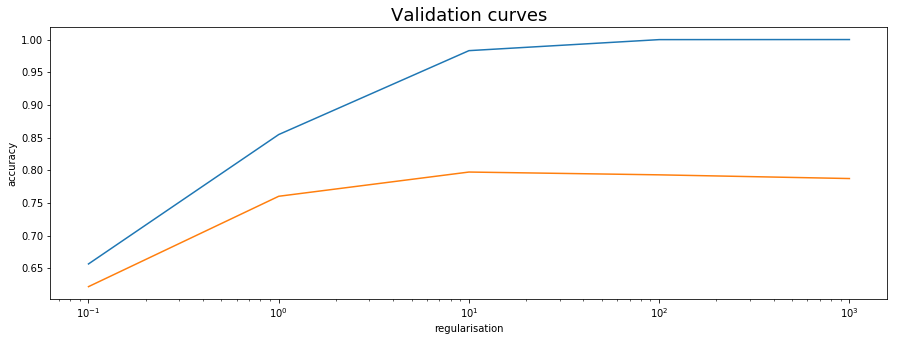

In [24]:
plt.figure(figsize=(15, 5))
plt.semilogx(param_grid['clf__C'], train_scores)
plt.semilogx(param_grid['clf__C'], test_scores)
plt.title("Validation curves", size=18)
plt.xlabel("regularisation")
plt.ylabel("accuracy")
plt.show()

## Viz

In [25]:
if bias_type == 'bias':
    bias = [Bias(v) for v in best_clf.predict(X_test)]
    cols = ['Bias.EXTREME_LEFT', 'Bias.LEFT', 'Bias.LEFT_CENTER', 'Bias.LEAST_BIASED', 'Bias.RIGHT_CENTER', 'Bias.RIGHT', 'Bias.EXTREME_RIGHT']
    ticks = ['EXT_LEFT', 'LEFT', 'LEFT_CENTER', 'UNBIASED', 'RIGHT_CENTER', 'RIGHT', 'EXTREME_RIGHT']
    k = 7
elif bias_type == 'simplified_bias':
    bias = [SimplifiedBias(v) for v in best_clf.predict(X_test)]
    cols = ['SimplifiedBias.LEFT', 'SimplifiedBias.UNBIASED', 'SimplifiedBias.RIGHT']
    ticks = ['LEFT', 'UNBIASED', 'RIGHT']
    k = 3
else:
    raise ValueError

df_test = df_test.assign(pred=pd.Series(bias).values)

In [26]:
dfc = df_test.copy()
dfc['bias'] = dfc['bias'].astype(str)
dfc['pred'] = dfc['pred'].astype(str)
r = dfc.groupby(['site', 'pred']).apply(lambda g: len(g)).unstack().fillna(0)[cols]

r = (r - r.mean(axis=0)) / np.sqrt(r.var(axis=0)) + (0 - ((r - r.mean(axis=0)) / np.sqrt(r.var(axis=0))).min())
r = r / np.repeat(r.sum(axis=1).values[:, None], k, axis=1)
r

pred,Bias.EXTREME_LEFT,Bias.LEFT,Bias.LEFT_CENTER,Bias.LEAST_BIASED,Bias.RIGHT_CENTER,Bias.RIGHT,Bias.EXTREME_RIGHT
site,,,,,,,
afp.com,0.000000,0.141022,0.377660,0.381946,0.078662,0.020710,0.000000
bbc.com,0.006856,0.000000,0.496676,0.461477,0.015996,0.000530,0.018464
bloomberg.com,0.011402,0.012673,0.364267,0.438891,0.145290,0.024685,0.002792
breitbart.com,0.011976,0.159030,0.145654,0.074012,0.018269,0.321306,0.269753
ijr.com,0.075451,0.234267,0.083090,0.000000,0.005208,0.435730,0.166254
nypost.com,0.006843,0.071254,0.530195,0.023903,0.099475,0.186237,0.082093
occupydemocrats.com,0.324884,0.306273,0.000000,0.003777,0.000000,0.128736,0.236330
rightwingnews.com,0.040160,0.089274,0.031941,0.003372,0.013514,0.400170,0.421569
talkingpointsmemo.com,0.068522,0.389181,0.312956,0.025944,0.032420,0.061167,0.109809


In [28]:
def viz(domain):
    plt.figure(figsize=(15, 2))
    plt.stem(r.ix[domain, :])
    plt.xticks(range(k), ticks, rotation=45)
    plt.title(domain, size=18)
    plt.show()

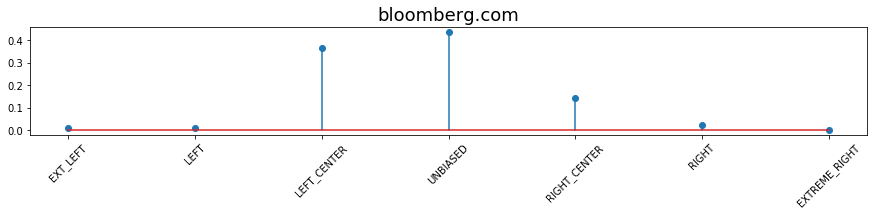

In [35]:
viz('bloomberg.com')

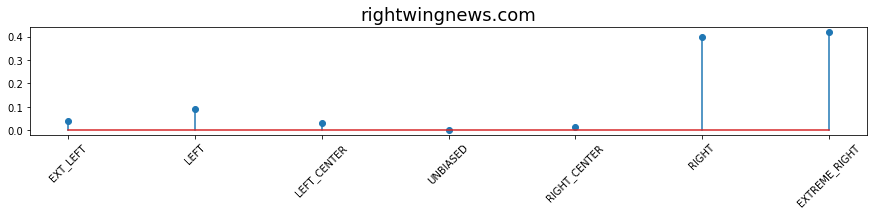

In [30]:
viz('rightwingnews.com')

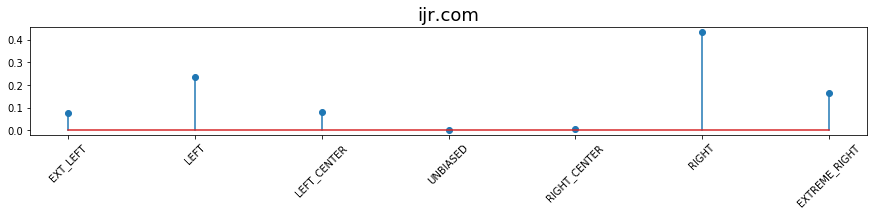

In [31]:
viz('ijr.com')

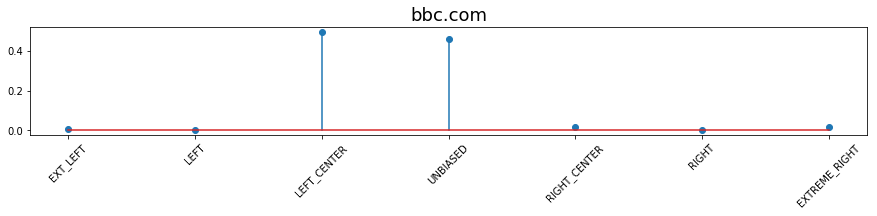

In [32]:
viz('bbc.com')

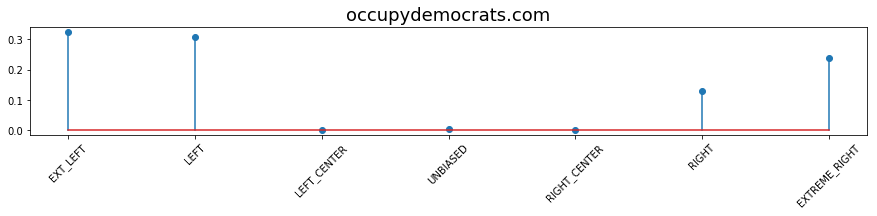

In [33]:
viz('occupydemocrats.com')

In [34]:
df_test[['title', 'site', 'bias', 'pred', 'simplified_bias']].iloc[:20, :]

,title,site,bias,pred,simplified_bias
6,NI budget: Extra £150m found in final deal,bbc.com,Bias.LEFT_CENTER,Bias.LEAST_BIASED,SimplifiedBias.UNBIASED
10,Constellation Taps Former Beam Executive as Ch...,wsj.com,Bias.RIGHT_CENTER,Bias.LEFT_CENTER,SimplifiedBias.UNBIASED
11,BBC News - Missing Seaford teenager: Woman arr...,bbc.com,Bias.LEFT_CENTER,Bias.LEFT_CENTER,SimplifiedBias.UNBIASED
31,Swiss Bank Shares Plummet After SNB Move - WSJ,wsj.com,Bias.RIGHT_CENTER,Bias.RIGHT_CENTER,SimplifiedBias.UNBIASED
34,Once-Blind Orangutan Returns to Indonesia’s Fo...,wsj.com,Bias.RIGHT_CENTER,Bias.RIGHT,SimplifiedBias.UNBIASED
43,Ingraham: GOP Establishment Now 'Firmly Entren...,breitbart.com,Bias.RIGHT,Bias.RIGHT,SimplifiedBias.RIGHT
50,Stoned to death and crucified: While the world...,rightwingnews.com,Bias.EXTREME_RIGHT,Bias.EXTREME_RIGHT,SimplifiedBias.RIGHT
59,Australian Open 2015 day two: Serena Williams ...,bbc.com,Bias.LEFT_CENTER,Bias.LEFT_CENTER,SimplifiedBias.UNBIASED
79,Hindustan Unilever Profit Rises 18%,wsj.com,Bias.RIGHT_CENTER,Bias.LEFT_CENTER,SimplifiedBias.UNBIASED
80,Vikings stadium will showcase Minnesota art,usatoday.com,Bias.LEAST_BIASED,Bias.LEFT_CENTER,SimplifiedBias.UNBIASED
